In [1]:
!pip install transformers datasets accelerate evaluate scikit-learn huggingface_hub torch
!pip install seqeval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForTokenClassification
from datasets import load_dataset
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


In [5]:
MODEL_PATH = "DipeshChaudhary/nepali-gec-binary-detector"
DATASET_NAME = "DipeshChaudhary/binary-nepali-ged-dataset"
BATCH_SIZE = 3072 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
print(f"🔧 Using device: {DEVICE}")


🔧 Using device: cuda


In [7]:
# Load model and tokenizer
print("📥 Loading model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForTokenClassification.from_pretrained(MODEL_PATH)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = torch.nn.DataParallel(model) 
model = model.to(DEVICE).eval()
print("✅ Model loaded successfully")


📥 Loading model and tokenizer...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/968 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/783 [00:00<?, ?B/s]

2025-11-10 15:46:17.507242: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762789577.710699      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762789577.768777      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

Using 2 GPUs
✅ Model loaded successfully


In [8]:
# Load dataset
print("📥 Loading dataset...")
dataset = load_dataset(DATASET_NAME)
calibration_set = dataset["test"]  # Using test as calibration
validation_set = dataset["validation"]  # Using validation for final eval

print(f"📊 Calibration set size: {len(calibration_set):,}")
print(f"📊 Validation set size: {len(validation_set):,}")


📥 Loading dataset...


README.md:   0%|          | 0.00/706 [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

data/train-00004-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00000-of-00072.parquet:   0%|          | 0.00/8.74M [00:00<?, ?B/s]

data/train-00007-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00009-of-00072.parquet:   0%|          | 0.00/8.74M [00:00<?, ?B/s]

data/train-00005-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00003-of-00072.parquet:   0%|          | 0.00/8.74M [00:00<?, ?B/s]

data/train-00008-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00011-of-00072.parquet:   0%|          | 0.00/8.74M [00:00<?, ?B/s]

data/train-00014-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00001-of-00072.parquet:   0%|          | 0.00/8.75M [00:00<?, ?B/s]

data/train-00015-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00002-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00010-of-00072.parquet:   0%|          | 0.00/8.74M [00:00<?, ?B/s]

data/train-00013-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00012-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00006-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00016-of-00072.parquet:   0%|          | 0.00/8.74M [00:00<?, ?B/s]

data/train-00017-of-00072.parquet:   0%|          | 0.00/8.74M [00:00<?, ?B/s]

data/train-00018-of-00072.parquet:   0%|          | 0.00/8.71M [00:00<?, ?B/s]

data/train-00019-of-00072.parquet:   0%|          | 0.00/8.74M [00:00<?, ?B/s]

data/train-00020-of-00072.parquet:   0%|          | 0.00/8.74M [00:00<?, ?B/s]

data/train-00022-of-00072.parquet:   0%|          | 0.00/8.74M [00:00<?, ?B/s]

data/train-00021-of-00072.parquet:   0%|          | 0.00/8.74M [00:00<?, ?B/s]

data/train-00023-of-00072.parquet:   0%|          | 0.00/8.74M [00:00<?, ?B/s]

data/train-00024-of-00072.parquet:   0%|          | 0.00/8.74M [00:00<?, ?B/s]

data/train-00025-of-00072.parquet:   0%|          | 0.00/8.74M [00:00<?, ?B/s]

data/train-00028-of-00072.parquet:   0%|          | 0.00/8.75M [00:00<?, ?B/s]

data/train-00027-of-00072.parquet:   0%|          | 0.00/8.75M [00:00<?, ?B/s]

data/train-00029-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00026-of-00072.parquet:   0%|          | 0.00/8.76M [00:00<?, ?B/s]

data/train-00030-of-00072.parquet:   0%|          | 0.00/8.75M [00:00<?, ?B/s]

data/train-00031-of-00072.parquet:   0%|          | 0.00/8.72M [00:00<?, ?B/s]

data/train-00033-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00032-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00035-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00034-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00037-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00036-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00038-of-00072.parquet:   0%|          | 0.00/8.74M [00:00<?, ?B/s]

data/train-00039-of-00072.parquet:   0%|          | 0.00/8.74M [00:00<?, ?B/s]

data/train-00040-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00041-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00042-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00044-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00043-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00045-of-00072.parquet:   0%|          | 0.00/8.74M [00:00<?, ?B/s]

data/train-00046-of-00072.parquet:   0%|          | 0.00/8.72M [00:00<?, ?B/s]

data/train-00047-of-00072.parquet:   0%|          | 0.00/8.74M [00:00<?, ?B/s]

data/train-00048-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00049-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00050-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00051-of-00072.parquet:   0%|          | 0.00/8.74M [00:00<?, ?B/s]

data/train-00052-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00054-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00053-of-00072.parquet:   0%|          | 0.00/8.74M [00:00<?, ?B/s]

data/train-00055-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00057-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00056-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00058-of-00072.parquet:   0%|          | 0.00/8.74M [00:00<?, ?B/s]

data/train-00059-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00060-of-00072.parquet:   0%|          | 0.00/8.72M [00:00<?, ?B/s]

data/train-00061-of-00072.parquet:   0%|          | 0.00/8.74M [00:00<?, ?B/s]

data/train-00062-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00064-of-00072.parquet:   0%|          | 0.00/8.72M [00:00<?, ?B/s]

data/train-00065-of-00072.parquet:   0%|          | 0.00/8.74M [00:00<?, ?B/s]

data/train-00063-of-00072.parquet:   0%|          | 0.00/8.74M [00:00<?, ?B/s]

data/train-00067-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00066-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00068-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00069-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00071-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/train-00070-of-00072.parquet:   0%|          | 0.00/8.73M [00:00<?, ?B/s]

data/validation-00000-of-00014.parquet:   0%|          | 0.00/8.44M [00:00<?, ?B/s]

data/validation-00001-of-00014.parquet:   0%|          | 0.00/8.45M [00:00<?, ?B/s]

data/validation-00002-of-00014.parquet:   0%|          | 0.00/8.43M [00:00<?, ?B/s]

data/validation-00003-of-00014.parquet:   0%|          | 0.00/8.44M [00:00<?, ?B/s]

data/validation-00004-of-00014.parquet:   0%|          | 0.00/8.44M [00:00<?, ?B/s]

data/validation-00005-of-00014.parquet:   0%|          | 0.00/8.44M [00:00<?, ?B/s]

data/validation-00006-of-00014.parquet:   0%|          | 0.00/8.43M [00:00<?, ?B/s]

data/validation-00007-of-00014.parquet:   0%|          | 0.00/8.43M [00:00<?, ?B/s]

data/validation-00008-of-00014.parquet:   0%|          | 0.00/8.44M [00:00<?, ?B/s]

data/validation-00009-of-00014.parquet:   0%|          | 0.00/8.43M [00:00<?, ?B/s]

data/validation-00010-of-00014.parquet:   0%|          | 0.00/8.44M [00:00<?, ?B/s]

data/validation-00011-of-00014.parquet:   0%|          | 0.00/8.44M [00:00<?, ?B/s]

data/validation-00012-of-00014.parquet:   0%|          | 0.00/8.44M [00:00<?, ?B/s]

data/validation-00013-of-00014.parquet:   0%|          | 0.00/8.44M [00:00<?, ?B/s]

data/test-00000-of-00005.parquet:   0%|          | 0.00/7.89M [00:00<?, ?B/s]

data/test-00001-of-00005.parquet:   0%|          | 0.00/7.89M [00:00<?, ?B/s]

data/test-00002-of-00005.parquet:   0%|          | 0.00/7.88M [00:00<?, ?B/s]

data/test-00003-of-00005.parquet:   0%|          | 0.00/7.89M [00:00<?, ?B/s]

data/test-00004-of-00005.parquet:   0%|          | 0.00/7.89M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/13008711 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2439231 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/813050 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/72 [00:00<?, ?it/s]

📊 Calibration set size: 813,050
📊 Validation set size: 2,439,231


In [9]:
def get_predictions_with_probabilities(dataset_split, batch_size=BATCH_SIZE):
    all_probs = []
    all_labels = []
    model.eval()
    
    with torch.no_grad():
        for i in tqdm(range(0, len(dataset_split), batch_size)):
            batch = dataset_split[i:i+batch_size]
            input_ids = torch.tensor(batch["input_ids"]).to(DEVICE)
            attention_mask = torch.tensor(batch["attention_mask"]).to(DEVICE)
            labels = batch["binary_labels"]
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            # Convert to probabilities
            probs = torch.softmax(logits, dim=-1)
            
            # Get probability of ERROR class (class 1)
            error_probs = probs[:, :, 1].cpu().numpy()
            
            # Process each example in batch
            for j in range(len(labels)):
                example_labels = labels[j]
                example_probs = error_probs[j]
                
                # Filter out padding (-100)
                valid_indices = [k for k, label in enumerate(example_labels) if label != -100]
                
                if valid_indices:
                    valid_probs = example_probs[valid_indices]
                    valid_labels = [example_labels[k] for k in valid_indices]
                    
                    all_probs.extend(valid_probs.tolist())
                    all_labels.extend(valid_labels)
    
    return np.array(all_probs), np.array(all_labels)

In [10]:
def compute_metrics_at_threshold(probs, labels, threshold):
    """Compute metrics at a specific threshold."""
    predictions = (probs >= threshold).astype(int)
    
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='binary', zero_division=0
    )
    
    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
    
    # Additional metrics
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    return {
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'specificity': specificity,
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn
    }


In [11]:
def find_optimal_threshold(probs, labels, metric='f1', thresholds=None):
    """Find optimal threshold based on specified metric."""
    if thresholds is None:
        thresholds = np.arange(0.1, 0.95, 0.01)
    
    results = []
    print(f"\n🔍 Testing {len(thresholds)} thresholds...")
    
    for threshold in tqdm(thresholds, desc="Testing thresholds"):
        metrics = compute_metrics_at_threshold(probs, labels, threshold)
        results.append(metrics)
    
    # Find optimal based on metric
    metric_values = [r[metric] for r in results]
    optimal_idx = np.argmax(metric_values)
    optimal_result = results[optimal_idx]
    
    return optimal_result, results


In [12]:
def plot_threshold_analysis(results, optimal_threshold):
    """Plot metrics vs threshold."""
    thresholds = [r['threshold'] for r in results]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Threshold Analysis', fontsize=16, fontweight='bold')
    
    # Plot 1: F1, Precision, Recall
    ax1 = axes[0, 0]
    ax1.plot(thresholds, [r['f1'] for r in results], label='F1', linewidth=2)
    ax1.plot(thresholds, [r['precision'] for r in results], label='Precision', linewidth=2)
    ax1.plot(thresholds, [r['recall'] for r in results], label='Recall', linewidth=2)
    ax1.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal ({optimal_threshold:.3f})')
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Score')
    ax1.set_title('F1, Precision, and Recall vs Threshold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Accuracy
    ax2 = axes[0, 1]
    ax2.plot(thresholds, [r['accuracy'] for r in results], linewidth=2, color='green')
    ax2.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal ({optimal_threshold:.3f})')
    ax2.set_xlabel('Threshold')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy vs Threshold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Precision-Recall curve
    ax3 = axes[1, 0]
    precisions = [r['precision'] for r in results]
    recalls = [r['recall'] for r in results]
    ax3.plot(recalls, precisions, linewidth=2)
    ax3.set_xlabel('Recall')
    ax3.set_ylabel('Precision')
    ax3.set_title('Precision-Recall Curve')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Specificity and Recall
    ax4 = axes[1, 1]
    ax4.plot(thresholds, [r['recall'] for r in results], label='Recall (Sensitivity)', linewidth=2)
    ax4.plot(thresholds, [r['specificity'] for r in results], label='Specificity', linewidth=2)
    ax4.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal ({optimal_threshold:.3f})')
    ax4.set_xlabel('Threshold')
    ax4.set_ylabel('Score')
    ax4.set_title('Sensitivity and Specificity vs Threshold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('threshold_analysis.png', dpi=300, bbox_inches='tight')
    print("📊 Plot saved as 'threshold_analysis.png'")
    plt.show()



In [13]:
# Main execution
print("\n" + "="*60)
print("STAGE 1: CALIBRATION (Using Test Set)")
print("="*60)

# Get predictions on calibration set (test set)
print("\n📊 Getting predictions on calibration set...")
calib_probs, calib_labels = get_predictions_with_probabilities(calibration_set)

print(f"✅ Got {len(calib_probs):,} token predictions")
print(f"   Class distribution - KEEP: {(calib_labels == 0).sum():,}, ERROR: {(calib_labels == 1).sum():,}")

# Find optimal threshold
print("\n🎯 Finding optimal threshold...")
optimal_result, all_results = find_optimal_threshold(
    calib_probs, 
    calib_labels, 
    metric='f1'
)



STAGE 1: CALIBRATION (Using Test Set)

📊 Getting predictions on calibration set...


100%|██████████| 265/265 [49:54<00:00, 11.30s/it]


✅ Got 11,912,920 token predictions
   Class distribution - KEEP: 11,268,670, ERROR: 644,250

🎯 Finding optimal threshold...

🔍 Testing 85 thresholds...


Testing thresholds: 100%|██████████| 85/85 [33:03<00:00, 23.34s/it]


In [14]:
print("\n" + "="*60)
print("OPTIMAL THRESHOLD RESULTS (Calibration Set)")
print("="*60)
print(f"🎯 Optimal Threshold: {optimal_result['threshold']:.4f}")
print(f"\n📊 Metrics at Optimal Threshold:")
print(f"   Accuracy:    {optimal_result['accuracy']:.4f}")
print(f"   Precision:   {optimal_result['precision']:.4f}")
print(f"   Recall:      {optimal_result['recall']:.4f}")
print(f"   F1 Score:    {optimal_result['f1']:.4f}")
print(f"   Specificity: {optimal_result['specificity']:.4f}")
print(f"\n📊 Confusion Matrix:")
print(f"   True Negatives:  {optimal_result['tn']:,}")
print(f"   False Positives: {optimal_result['fp']:,}")
print(f"   False Negatives: {optimal_result['fn']:,}")
print(f"   True Positives:  {optimal_result['tp']:,}")




OPTIMAL THRESHOLD RESULTS (Calibration Set)
🎯 Optimal Threshold: 0.4200

📊 Metrics at Optimal Threshold:
   Accuracy:    0.9873
   Precision:   0.9203
   Recall:      0.8376
   F1 Score:    0.8770
   Specificity: 0.9959

📊 Confusion Matrix:
   True Negatives:  11,221,962
   False Positives: 46,708
   False Negatives: 104,651
   True Positives:  539,599



📈 Generating threshold analysis plots...
📊 Plot saved as 'threshold_analysis.png'


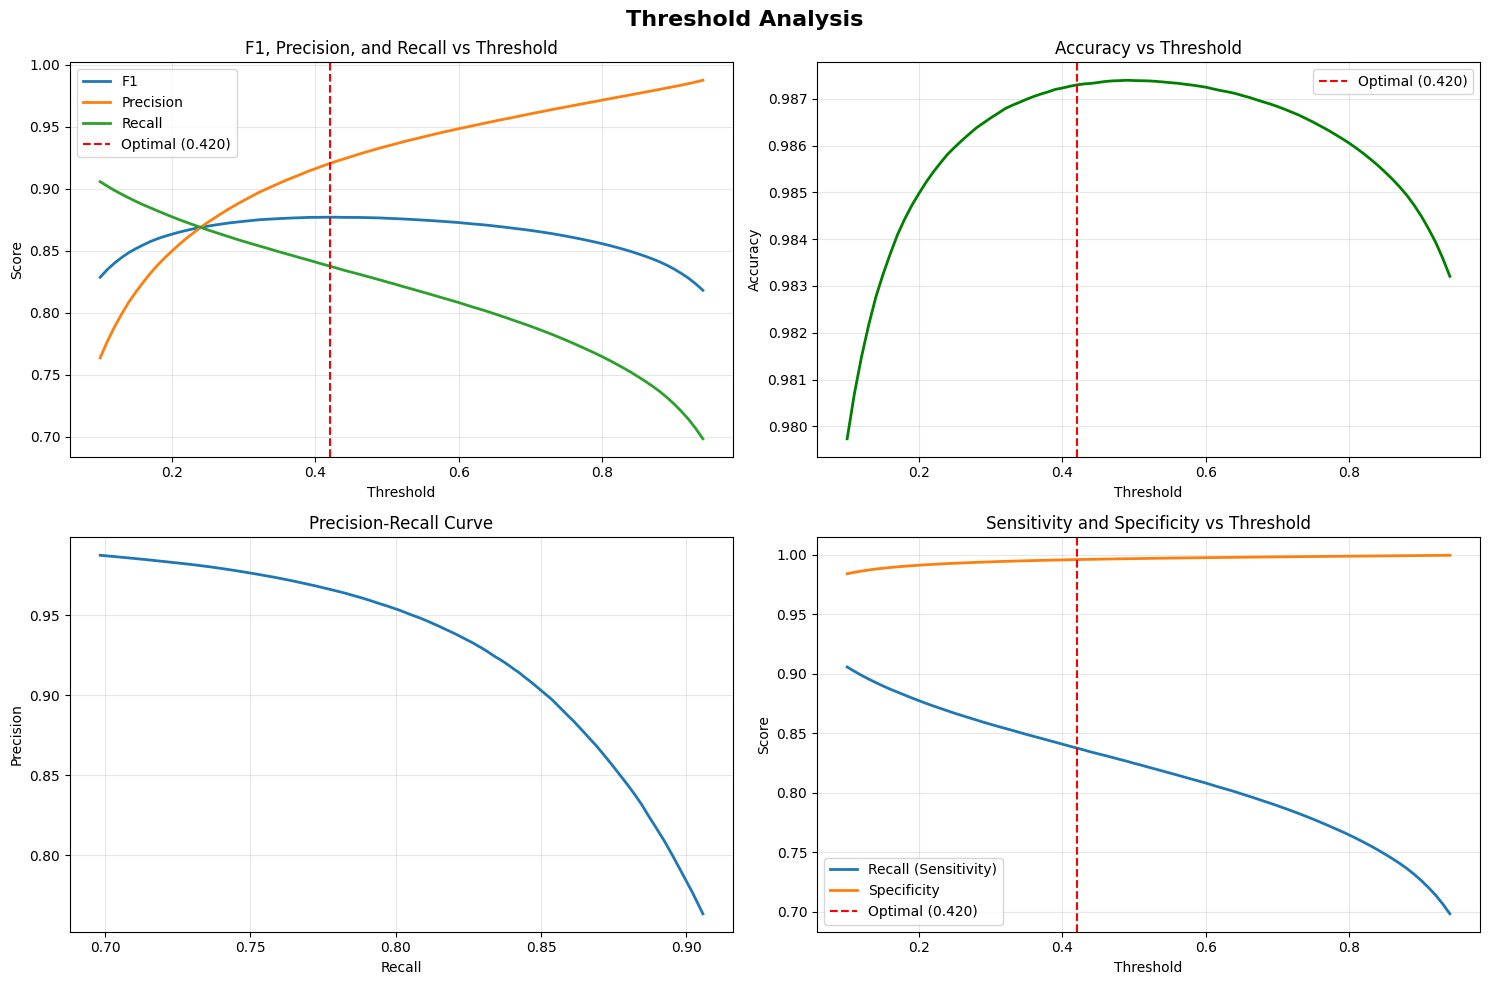


STAGE 2: VALIDATION (Using Validation Set)

📊 Getting predictions on validation set...


 25%|██▌       | 202/795 [38:08<1:52:59, 11.43s/it]

In [ ]:
# Plot results
print("\n📈 Generating threshold analysis plots...")
plot_threshold_analysis(all_results, optimal_result['threshold'])

# Evaluate on validation set with optimal threshold
print("\n" + "="*60)
print("STAGE 2: VALIDATION (Using Validation Set)")
print("="*60)

print("\n📊 Getting predictions on validation set...")
val_probs, val_labels = get_predictions_with_probabilities(validation_set)

In [ ]:
print(f"✅ Got {len(val_probs):,} token predictions")

# Apply optimal threshold
val_result = compute_metrics_at_threshold(
    val_probs, 
    val_labels, 
    optimal_result['threshold']
)

print("\n" + "="*60)
print("VALIDATION SET RESULTS (With Optimal Threshold)")
print("="*60)
print(f"🎯 Applied Threshold: {val_result['threshold']:.4f}")
print(f"\n📊 Metrics:")
print(f"   Accuracy:    {val_result['accuracy']:.4f}")
print(f"   Precision:   {val_result['precision']:.4f}")
print(f"   Recall:      {val_result['recall']:.4f}")
print(f"   F1 Score:    {val_result['f1']:.4f}")
print(f"   Specificity: {val_result['specificity']:.4f}")
print(f"\n📊 Confusion Matrix:")
print(f"   True Negatives:  {val_result['tn']:,}")
print(f"   False Positives: {val_result['fp']:,}")
print(f"   False Negatives: {val_result['fn']:,}")
print(f"   True Positives:  {val_result['tp']:,}")

# Compare default threshold (0.5) vs optimal
print("\n" + "="*60)
print("COMPARISON: Default (0.5) vs Optimal Threshold")
print("="*60)

default_result = compute_metrics_at_threshold(val_probs, val_labels, 0.5)

print(f"\n📊 Default Threshold (0.5):")
print(f"   F1 Score: {default_result['f1']:.4f}")
print(f"   Precision: {default_result['precision']:.4f}")
print(f"   Recall: {default_result['recall']:.4f}")

print(f"\n📊 Optimal Threshold ({optimal_result['threshold']:.4f}):")
print(f"   F1 Score: {val_result['f1']:.4f} (Δ {val_result['f1'] - default_result['f1']:+.4f})")
print(f"   Precision: {val_result['precision']:.4f} (Δ {val_result['precision'] - default_result['precision']:+.4f})")
print(f"   Recall: {val_result['recall']:.4f} (Δ {val_result['recall'] - default_result['recall']:+.4f})")

# Save optimal threshold
print(f"\n💾 Saving optimal threshold to 'optimal_threshold.txt'...")
with open('optimal_threshold.txt', 'w') as f:
    f.write(f"Optimal Threshold: {optimal_result['threshold']:.4f}\n")
    f.write(f"\nCalibration Set Metrics:\n")
    f.write(f"F1: {optimal_result['f1']:.4f}\n")
    f.write(f"Precision: {optimal_result['precision']:.4f}\n")
    f.write(f"Recall: {optimal_result['recall']:.4f}\n")
    f.write(f"\nValidation Set Metrics:\n")
    f.write(f"F1: {val_result['f1']:.4f}\n")
    f.write(f"Precision: {val_result['precision']:.4f}\n")
    f.write(f"Recall: {val_result['recall']:.4f}\n")

print("✅ Complete! Optimal threshold found and validated.")